In [71]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

from colossus.cosmology import cosmology
from colossus.lss import mass_function

In [47]:
# ler initialization
from ler.rates import LeR
from ler.utils import append_json, get_param_from_json

ler = LeR(verbose=False)

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:162: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:160: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)


## Define all necessary functions

In [25]:
# function to get the Einstein radius
def einstein_radius_nfw(M200, zl, zs, cosmo):

    M200 = M200 * u.M_sun.to(u.kg)  # Convert solar mass to kg
    # Constants in SI units
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    c = 299792458  # speed of light in m/s

    # Calculate critical density
    rho_crit = cosmo.critical_density(zl).to(u.kg / u.m**3).value

    # Calculate r200
    r200 = (3 * M200 / (4 * np.pi * 200 * rho_crit))**(1/3)

    # angular diameter distance
    d_A_L = cosmo.angular_diameter_distance(zl).to(u.m).value
    d_A_S = cosmo.angular_diameter_distance(zs).to(u.m).value
    d_A_LS = cosmo.angular_diameter_distance_z1z2(zl, zs).to(u.m).value

    # sigma_crit
    sigma_crit = c**2 / (4 * np.pi * G) * d_A_S / (d_A_L * d_A_LS)

    # Einstein radius
    # Einstein radius calculation
    theta_E = (M200 / (2 * r200 * sigma_crit * d_A_L))  # radians

    # Convert to arcseconds
    theta_E_arcsec = theta_E * 206265

    return theta_E_arcsec

# Empirical mass-concentration relation (Dutton & Macciò 2014)
def concentration(M200, z):
    A = 5.71
    B = -0.084
    C = -0.47
    c200 = A * (M200 / 1e12)**B * (1 + z)**C
    return c200

# 2D rejection sampling function
def rejection_sample2d(pdf, xmin, xmax, ymin, ymax, size=100, chunk_size=100):
    """
        Helper function for rejection sampling from a 2D pdf with maximum and minimum arguments.

        Parameters
        ----------
        pdf : `function`
            2D pdf function.
        xmin : `float`
            minimum value of the pdf in the x-axis.
        xmax : `float`
            maximum value of the pdf in the x-axis.
        ymin : `float`
            minimum value of the pdf in the y-axis.
        ymax : `float`
            maximum value of the pdf in the y-axis.
        size : `int`, optional
            number of samples. Default is 100.
        chunk_size : `int`, optional
            chunk size for sampling. Default is 10000.

        Returns
        ----------
        x_sample : `numpy.ndarray`
            samples from the pdf in the x-axis.
    """

    x = np.random.uniform(xmin, xmax, chunk_size) # M
    y = np.random.uniform(ymin, ymax, chunk_size) # z

    # find the pdf value at x and y
    z = np.zeros(chunk_size)
    for i in range(chunk_size):
        z[i] = pdf(x[i], y[i])

    # Maximum value of the pdf
    zmax = np.max(z)
    
    # Rejection sample in chunks
    x_sample = []
    y_sample = []
    pdf_sample = []
    while len(x_sample) < size:
        x_try = np.random.uniform(xmin, xmax, size=chunk_size)
        y_try = np.random.uniform(ymin, ymax, size=chunk_size)
        pdf_xy_try = np.zeros(chunk_size)
        for i in range(chunk_size):
            pdf_xy_try[i] = pdf(x_try[i], y_try[i])

        # this is for comparing with the pdf value at x_try, will be used to accept or reject the sample
        z_try = np.random.uniform(0, zmax, size=chunk_size)
        
        # Update the maximum value of the pdf
        zmax = max(zmax, np.max(pdf_xy_try))

        idx = z_try < pdf_xy_try
        x_sample += list(x_try[idx])
        y_sample += list(y_try[idx])
        pdf_sample += list(pdf_xy_try[idx])

    # Transform the samples to a 1D numpy array
    x_sample = np.array(x_sample).flatten()
    y_sample = np.array(y_sample).flatten()
    pdf_sample = np.array(pdf_sample).flatten()
    # Return the correct number of samples
    return x_sample[-size:], y_sample[-size:], pdf_sample[-size:]

## Source redshift sampling

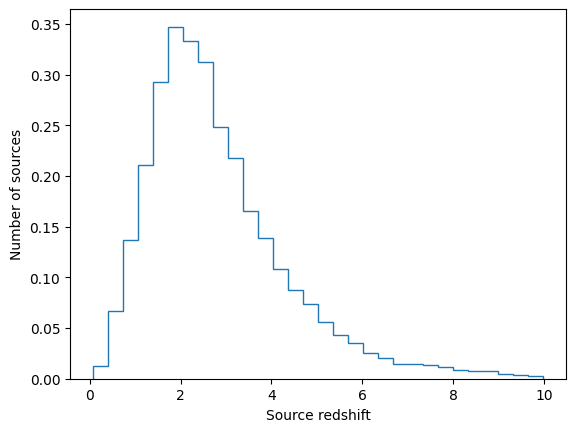

In [18]:
zs = ler.sample_source_redshift(10000)

# plot
plt.hist(zs, bins=30, histtype='step', density=True)
plt.xlabel('Source redshift')
plt.ylabel('Number of sources')
plt.show()

## Lens redshift and lens mass sampling.

In [38]:
# Set up the cosmology
cosmology.setCosmology('planck18')

# test
# Define the mass and redshift range
M = np.logspace(14, 16, 1000)  # Mass range from 10^14 to 10^16 solar masses
z = np.geomspace(0.2, 10, 1000)  # Redshift range from 0 to 10

# Calculate the halo mass function
hmf = np.zeros((len(M), len(z)))
for i in range(len(M)):
    for j in range(len(z)):
        hmf[i, j] = mass_function.massFunction(M[i], z[j], mdef = '200c', model = 'tinker08', q_out = 'dndlnM')

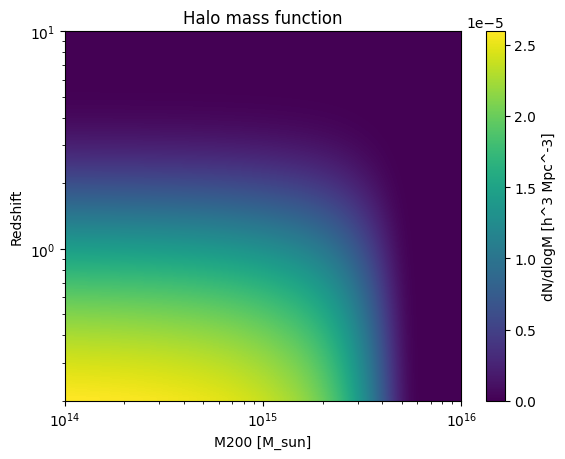

In [39]:
# Plot the halo mass function
# use imshow to plot the 2D array
plt.imshow(hmf, extent=(M[0], M[-1], z[0], z[-1]), aspect='auto', origin='lower')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M200 [M_sun]')
plt.ylabel('Redshift')
plt.title('Halo mass function')
plt.colorbar(label='dN/dlogM [h^3 Mpc^-3]')
plt.show()

In [30]:
# halo mass function as lambda function
halo_mass_function = lambda M, z: mass_function.massFunction(M, z, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')

In [33]:
# this will take a while
# the sample will be save. so you can load it later
m_sample, zl_sample, pdf_sample = rejection_sample2d(
    pdf=halo_mass_function, 
    xmin=1e14,
    xmax=6e16,  # in rejection sampling, the maximum value of the pdf is not needed
    ymin=0.2,
    ymax=2,  # in rejection sampling, the maximum value of the pdf is not needed
    size=1000, 
    chunk_size=100000,
)

In [51]:
# save m_sample and zl_sample , zs
dict_ = {'zs': zs, 'm_sample': m_sample, 'zl_sample': zl_sample}
append_json('ler_data/halo_mass_sample.json', dict_, replace=True);


In [53]:
# load the sample
dict_ = get_param_from_json('ler_data/halo_mass_sample.json')
zs = dict_['zs']
m_sample = dict_['m_sample']
zl_sample = dict_['zl_sample']

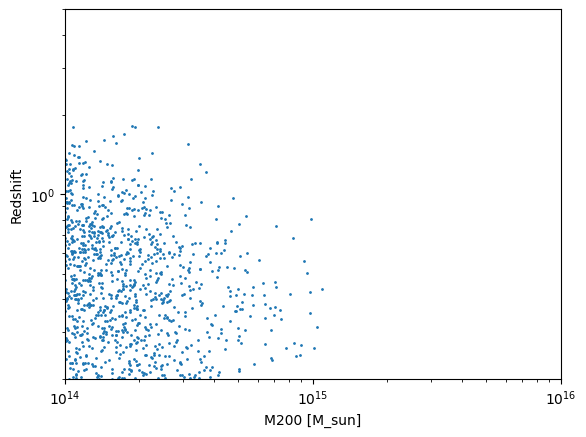

In [54]:
# scatter plot of the randomly drawn halo masses
plt.scatter(m_sample, zl_sample, s=1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Redshift')
plt.xlabel('M200 [M_sun]')
plt.xlim(1e14, 1e16)
plt.ylim(0.2, 5)
plt.show()

In [55]:
# selecting zl wrt to the source redshift
zs_final = []
zl_final = []
M200_final = []
for zs_sample in zs:
    
    idx1 = np.where(zl_sample<zs_sample)[0]
    if np.sum(idx1) > 0:
        zs_final.append(zs_sample)
        
        # randomly select a lens redshift
        idx2 = np.random.choice(idx1)

        # zl
        zl_final.append(zl_sample[idx2])
        # M200
        M200_final.append(m_sample[idx2])


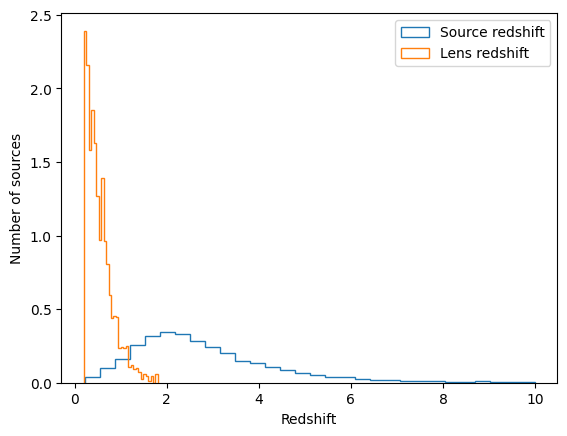

In [56]:
# plot zs and zl
plt.hist(zs_final, bins=30, histtype='step', density=True, label='Source redshift')
plt.hist(zl_final, bins=30, histtype='step', density=True, label='Lens redshift')
plt.xlabel('Redshift')
plt.ylabel('Number of sources')
plt.legend()
plt.show()

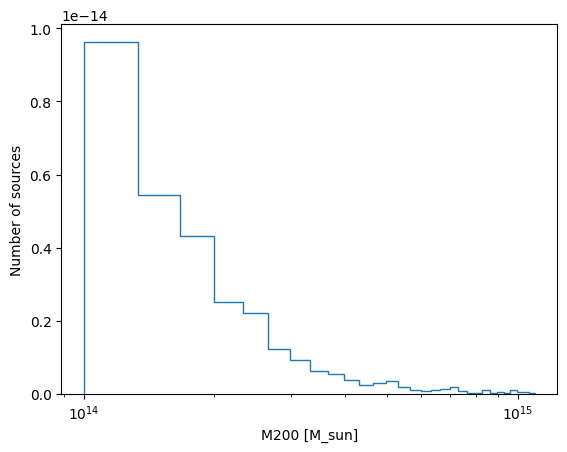

In [57]:
# mass distribution
plt.hist(M200_final, bins=30, histtype='step', density=True)
plt.xscale('log')
plt.xlabel('M200 [M_sun]')
plt.ylabel('Number of sources')
plt.show()

In [113]:
num = 5000
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)  # Example values
# Lens and source redshift
z_s = np.array(zs_final[:num])
z_l = np.array(zl_final[:num])
M200 = np.array(M200_final[:num])

# Calculate concentration parameter
c200 = concentration(M200, z_l)

alpha_Rs = np.zeros(num)
Rs = np.zeros(num)
theta_E = np.zeros(num)

for i in range(num):
    
    lens_cosmo = LensCosmo(z_lens=z_l[i], z_source=z_s[i], cosmo=cosmology)

    # Convert M200 to lensing parameters
    Rs_angle_, alpha_Rs_ = lens_cosmo.nfw_physical2angle(M=M200[i], c=c200[i])

    rho0_, Rs_, c_, r200_, M200_ = lens_cosmo.nfw_angle2physical(Rs_angle=Rs_angle, alpha_Rs=alpha_Rs)

    alpha_Rs[i] = alpha_Rs_
    Rs[i] = Rs_

    # Calculate the Einstein radius
    theta_E[i] = einstein_radius_nfw(M200[i], z_l[i], z_s[i], cosmology)

In [114]:
num2 = 100 # number of source positions in each iteration
lens_model_list = ['NFW']

# to test for multiple source positions
x_image_arr, y_image_arr = [], []
mag_arr = []
dt_arr = []
for i in range(num):

    lens_model = LensModel(lens_model_list, z_lens=z_l[i], z_source=z_s[i])
    kwargs_nfw = [{'Rs': Rs[i], 'alpha_Rs': alpha_Rs[i], 'center_x': 0, 'center_y': 0}]
    solver = LensEquationSolver(lens_model)

    # for source position
    x_max = theta_E[i]*0.6

    mag_ = []
    dt_ = []
    iter_ = 0
    while len(mag_)<num2:

        x_source, y_source = np.random.uniform(0, x_max, 2)

        x_image, y_image = solver.image_position_from_source(
                        sourcePos_x=x_source,
                        sourcePos_y=y_source,
                        kwargs_lens=kwargs_nfw)
        # check two images are formed
        if len(x_image) >= 2:
            mag_buffer = abs(lens_model.magnification(x_image, y_image, kwargs_nfw))
            # check the magnification is greater than 1 for two images
            if np.sum(mag_buffer>=1) >= 2:
                mag_.append(list(mag_buffer))
                dt_.append(list(lens_model.arrival_time(x_image, y_image, kwargs_nfw)))
        iter_ += 1  # to avoid infinite loop
        if iter_ > 10:
            break

    mag_arr += mag_
    dt_arr += dt_

In [124]:
dt12 = []
dt13 = []
dt23 = []
for i in range(len(dt_arr)):
    
    dt12.append(dt_arr[i][1] - dt_arr[i][0])
    if len(dt_arr[i]) == 3 and mag_arr[i][2] >= 1:
        dt13.append(dt_arr[i][2] - dt_arr[i][0])
        dt23.append(dt_arr[i][2] - dt_arr[i][1])

In [125]:
len(dt13)

0

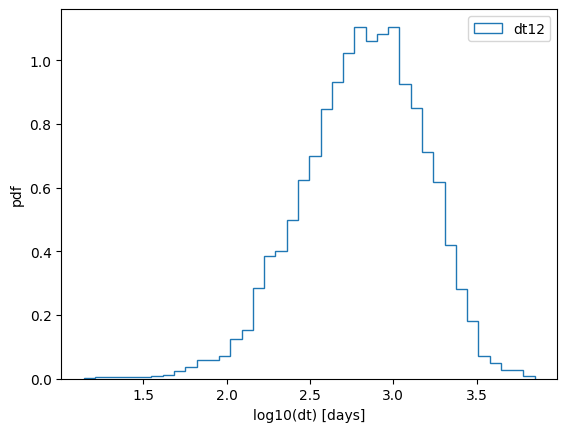

In [126]:
# plot the time delay log10(dt12) 
plt.hist(np.log10(dt12), bins=40, histtype='step', density=True, label='dt12')
# plt.hist(np.log10(dt13), bins=30, histtype='step', density=True, label='dt13')
# plt.hist(np.log10(dt23), bins=30, histtype='step', density=True, label='dt23')
plt.xlabel('log10(dt) [days]')
plt.ylabel('pdf')
plt.legend()
plt.show()

In [127]:
# save dt12, dt13, dt23
dict_ = {'dt12': dt12}
append_json('ler_data/cluster_time_delay_sample.json', dict_, replace=True);

## Galaxy lensing

In [118]:
ler = LeR(verbose=False)

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:162: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:160: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)


In [119]:
lens_param = ler.lensed_cbc_statistics(size=100000)

lensed params will be store in ./ler_data/lensed_param.json
chosen batch size = 50000 with total size = 100000
There will be 2 batche(s)
Batch no. 1
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:16<00:00, 3024.67it/s]


Invalid sample found. Resampling 1 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


calculating snrs...
Batch no. 2
sampling lensed params...
solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:15<00:00, 3279.30it/s]


Invalid sample found. Resampling 3 lensed events...
solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


calculating snrs...
saving all lensed_params in ./ler_data/lensed_param.json 


In [128]:
lens_param.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net', 'L1', 'H1', 'V1'])

In [138]:
# select only those with magnification greater than 1
mag = abs(lens_param['magnifications'])
# two or more images with mag>1 
idx = np.where(np.sum(mag>=1, axis=1)>=2)[0]
mag = mag[idx]

# time delay
dt = lens_param['time_delays']
dt = dt[idx]/(60*60*24)  # convert to days

In [141]:
dt12 = dt[:, 1] - dt[:, 0]
dt13 = dt[:, 2] - dt[:, 0]
dt14 = dt[:, 3] - dt[:, 0]
dt23 = dt[:, 2] - dt[:, 1]
dt24 = dt[:, 3] - dt[:, 1]
dt34 = dt[:, 3] - dt[:, 2]

In [144]:
# non nan values
idx = np.where(~np.isnan(dt12))[0]
dt12 = dt12[idx]
idx = np.where(~np.isnan(dt13))[0]
dt13 = dt13[idx]
idx = np.where(~np.isnan(dt14))[0]
dt14 = dt14[idx]
idx = np.where(~np.isnan(dt23))[0]
dt23 = dt23[idx]
idx = np.where(~np.isnan(dt24))[0]
dt24 = dt24[idx]
idx = np.where(~np.isnan(dt34))[0]
dt34 = dt34[idx]

In [145]:
# join 
dt_all = np.concatenate([dt12, dt13, dt14, dt23, dt24, dt34])

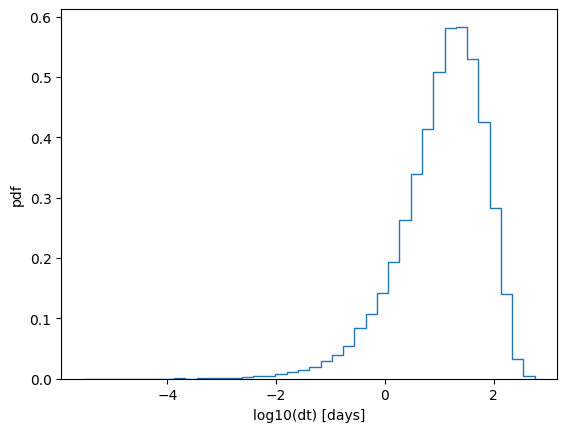

In [146]:
# plot the time delay log10(dt)
plt.hist(np.log10(dt_all), bins=40, histtype='step', density=True)
plt.xlabel('log10(dt) [days]')
plt.ylabel('pdf')
plt.show()


In [150]:
# save all time delays
dict_ = {'dt12': dt12, 'dt13': dt13, 'dt14': dt14, 'dt23': dt23, 'dt24': dt24, 'dt34': dt34, 'dt_all': dt_all}
append_json('ler_data/galaxy_time_delay_sample.json', dict_, replace=True);

## Plot comparison

In [147]:
# get cluster time delay sample
dict_ = get_param_from_json('ler_data/cluster_time_delay_sample.json')
dt12_cluster = dict_['dt12']

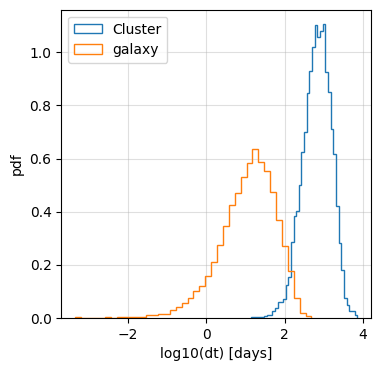

In [152]:
# plot comparison
plt.figure(figsize=(4, 4))
plt.hist(np.log10(dt12_cluster), bins=40, histtype='step', density=True, label='Cluster')
plt.hist(np.log10(dt12), bins=40, histtype='step', density=True, label='galaxy')
plt.xlabel('log10(dt) [days]')
plt.ylabel('pdf')
plt.legend()
plt.grid(alpha=0.4)
plt.show()